<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2023_1110Stroop_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade
    !git clone https://github.com/ShinAsakawa/bit.git
    import bit

import os
HOME = os.environ['HOME']

日付: 2023-11-13
HOSTNAME: Pasiphae
ユーザ名: asakawa
HOME: /Users/asakawa
ファイル名: study/2023notebooks/2023_1110Stroop_test.ipynb
torch.__version__: 2.0.1


In [ ]:
# 乱数のシードを設定
import numpy as np
import random
import sys

seed=42
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(seed)
batch_size = 64

In [ ]:
from bit import get_text_img
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

class stroop_Dataset(Dataset):
    def __init__(self):

        super().__init__()
        self.width, self.height = 224, 224
        self.bgcolor = (255,255,255)
        self.font_sizes=[28, 42, 56, 70, 84, 98]
        self.colors = ['black', 'red', 'green', 'blue', 'yellow']
        self.words  = ['黒', '赤', '緑', '青', '黄']
        fonts = []
        for font_size in self.font_sizes:
            _fonts = bit.get_notojp_fonts(fontsize=font_size, verbose=False)
            for _fontname, _font in _fonts.items():
                font_name = str(f'{font_size:03d}')+_fontname
                fonts.append((font_name, _font))
        self.fonts = fonts
        # self.image_transform = ImageTransform()

        cond = []
        for font in fonts:
            #_font = font
            size = int(font[0][:3])
            for color in self.colors:
                for word in self.words:
                    cond.append((color, word, size, font))
        self.cond = cond

    def __len__(self):
        return len(self.colors) * len(self.words) * len(self.fonts)

    def __getitem__(self, idx:int):

        color_ = self.cond[idx][0]
        word_  = self.cond[idx][1]
        size_  = self.cond[idx][2]
        font_name  = self.cond[idx][3][0]
        font_  = self.cond[idx][3][1]

        color_idx = self.colors.index(color_)
        word_idx  = self.words.index(word_)
        size_idx  = self.font_sizes.index(size_)

        # col = self.colors[color_idx]
        # wrd = self.words[word_idx]
        # font_size = int(self.fonts[font_idx][0][:3])
        # font_name = self.fonts[font_idx][0][3:]
        # font = self.fonts[font_idx][1]

        img, draw_canvas, bbox = get_text_img(
            text=word_,
            #text=wrd,
            color=color_,
            #color=col,
            draw_bbox=False,
            font=font_,
            #font=font,
        )

        # 画像を torch.Tensor に変換しないと，DataLoader でハンドリングできない
        _img = torch.tensor(
            (np.array(img)/255).clip(0,1).transpose(2,0,1),
            device=device,
            dtype=torch.float32,
        )

        return _img, {'color':self.colors.index(color_),
                     'word':self.words.index(word_),
                     'font_size':size_, 'font_name':font_name}

stroop_ds = stroop_Dataset()

In [ ]:
def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

N_train = int(stroop_ds.__len__() * 0.9)
N_test  = stroop_ds.__len__() - N_train
train_ds, val_ds = torch.utils.data.random_split(dataset=stroop_ds, lengths=(N_train, N_test))

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=_collate_fn
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=_collate_fn
)

train_dl.name = 'train'
val_dl.name = 'val'

149 {'color': 4, 'word': 4, 'font_size': 28, 'font_name': '028NotoSerifJP-SemiBold'}
1898 {'color': 4, 'word': 3, 'font_size': 98, 'font_name': '098NotoSerifJP-SemiBold'}
1943 {'color': 3, 'word': 3, 'font_size': 98, 'font_name': '098NotoSansJP-Thin'}
1813 {'color': 2, 'word': 3, 'font_size': 98, 'font_name': '098NotoSansJP-Regular'}
734 {'color': 1, 'word': 4, 'font_size': 56, 'font_name': '056NotoSerifJP-Medium'}
1128 {'color': 0, 'word': 3, 'font_size': 70, 'font_name': '070NotoSansJP-Medium'}
934 {'color': 1, 'word': 4, 'font_size': 56, 'font_name': '056NotoSansJP-Bold'}
690 {'color': 3, 'word': 0, 'font_size': 42, 'font_name': '042NotoSansJP-Black'}
2098 {'color': 4, 'word': 3, 'font_size': 98, 'font_name': '098NotoSansJP-Black'}
1871 {'color': 4, 'word': 1, 'font_size': 98, 'font_name': '098NotoSansJP-Light'}
298 {'color': 4, 'word': 3, 'font_size': 28, 'font_name': '028NotoSerifJP-Black'}
1751 {'color': 0, 'word': 1, 'font_size': 98, 'font_name': '098NotoSerifJP-Bold'}
889 {'col

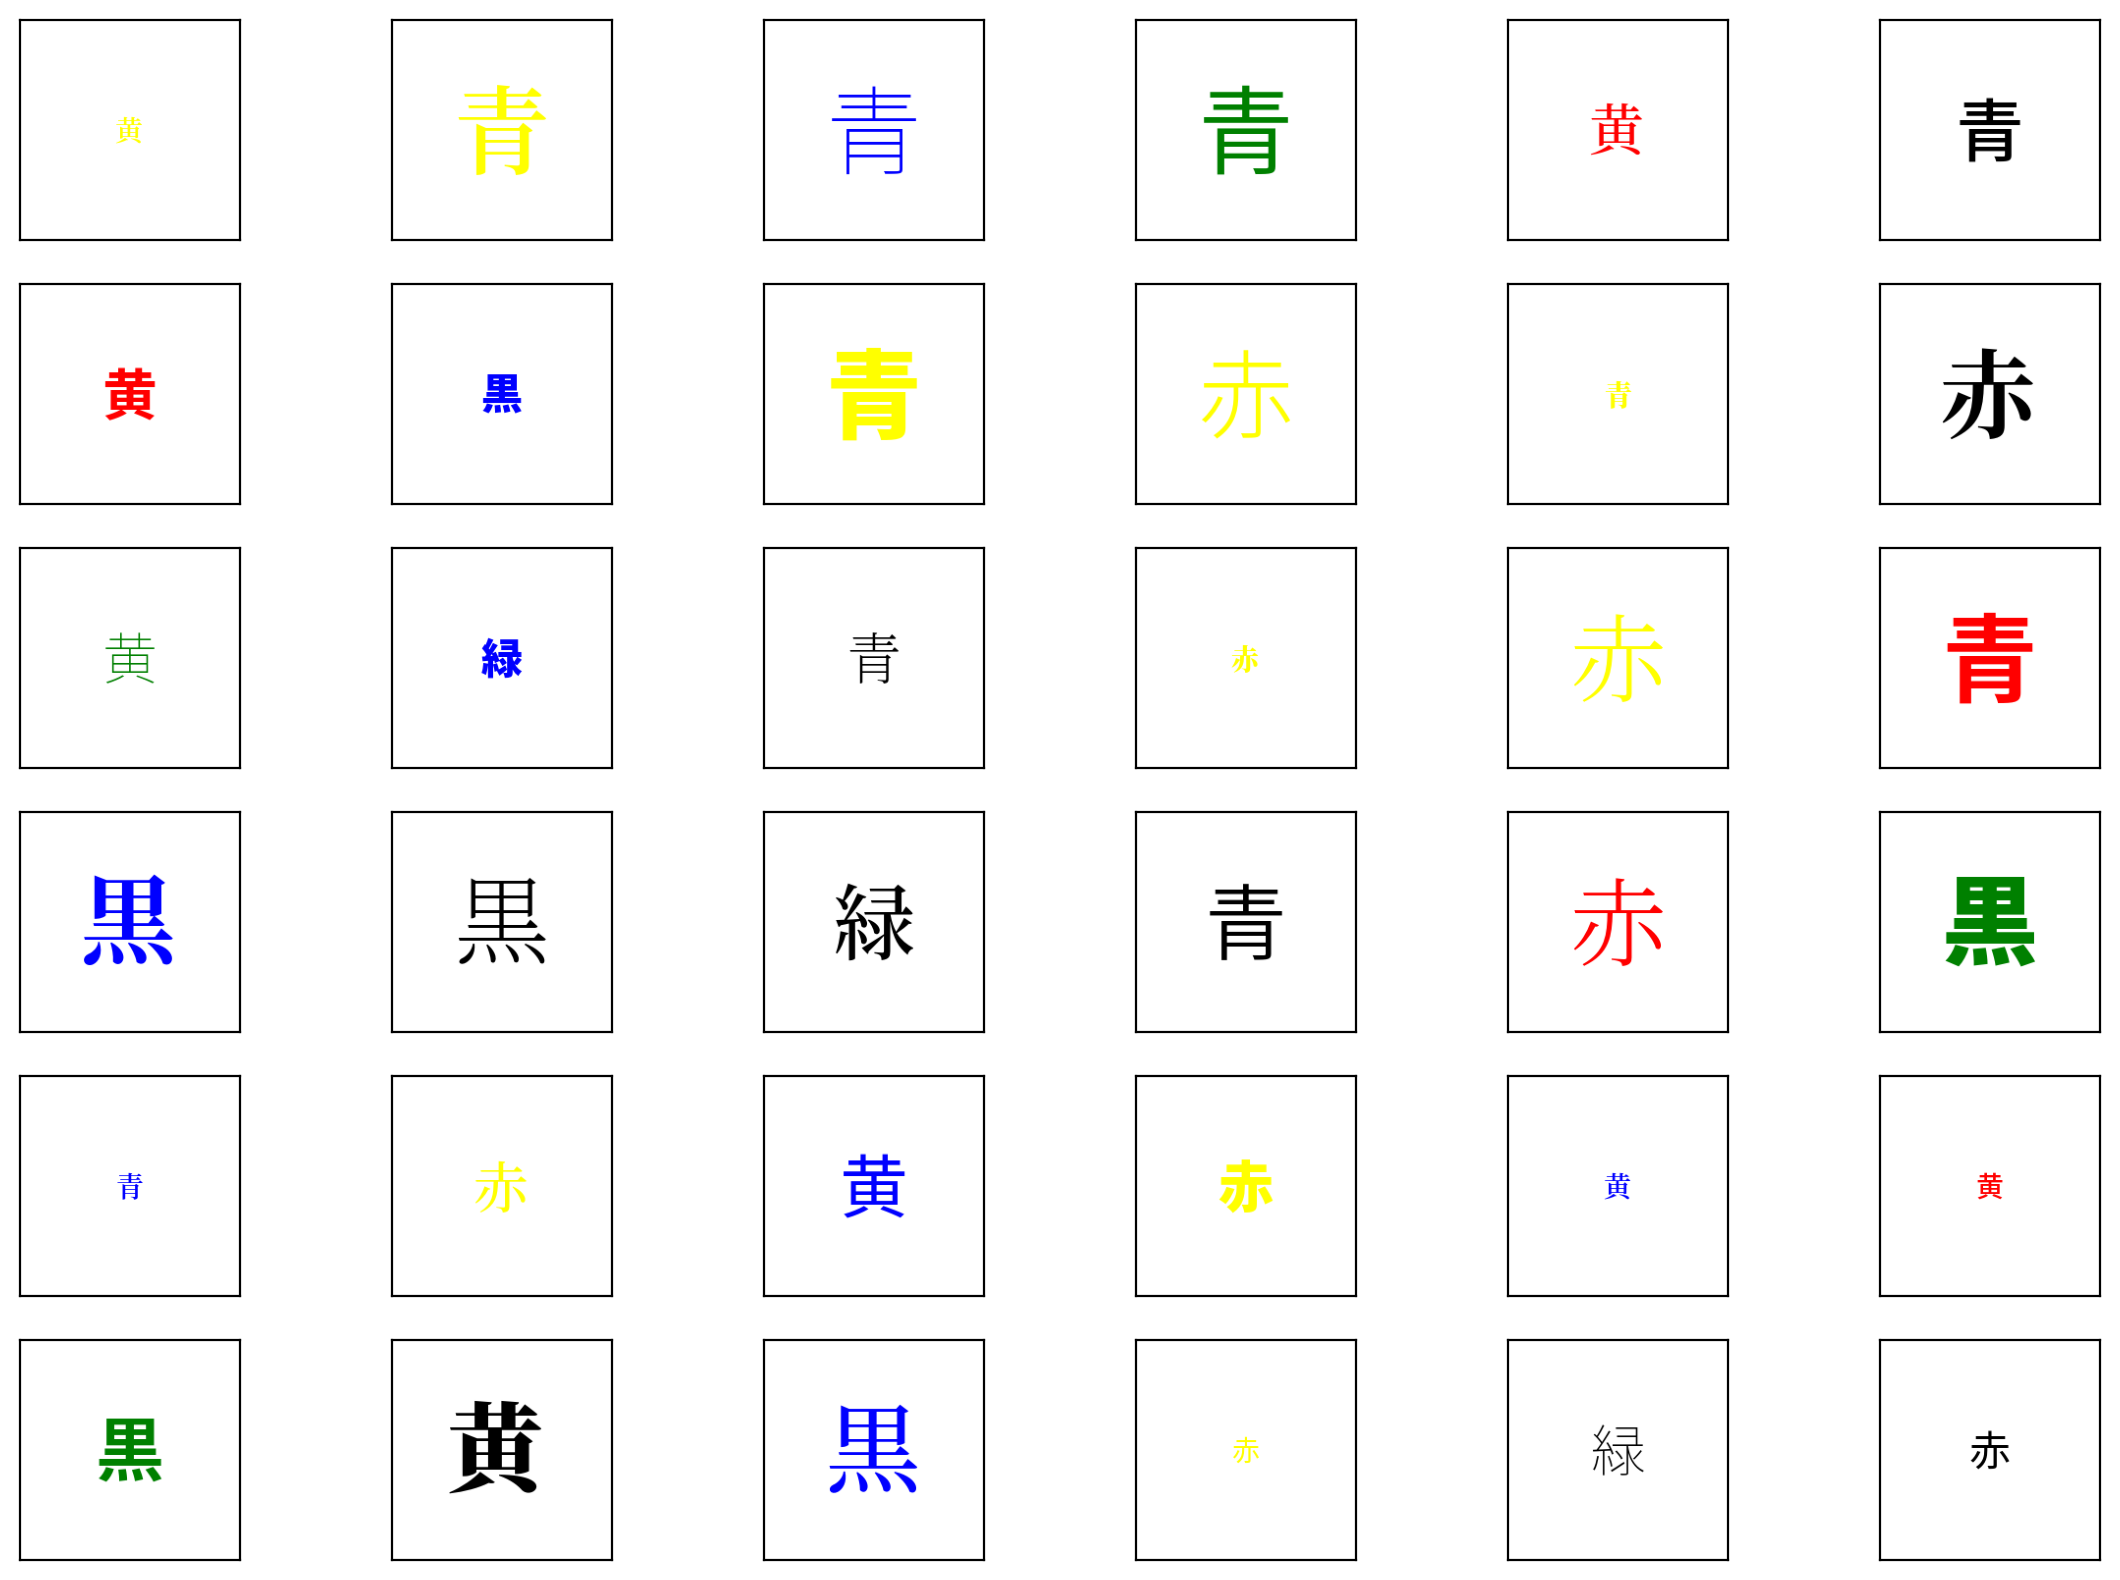

In [ ]:
fig, ax = plt.subplots(6, 6, figsize=(14, 10))
i, j = 0, 0
j_max = 6

Ns = np.random.permutation(stroop_ds.__len__())
for idx in Ns[:36]:
#for idx in range(36):
    #img, y = val_ds.__getitem__(idx)
    img, y = stroop_ds.__getitem__(idx)
    _img = img.detach().squeeze(0).numpy().transpose(1,2,0) # * 255
    print(idx,y)
    ax[i,j].imshow(_img)
    #ax[i,j].imshow(img)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    j += 1
    if j == j_max:
        i+=1; j=0

#plt.show()

In [ ]:
# 各モデルを定義し，訓練済み結合係数をダウンロード
import torchvision
from torchvision import models

DNNs = {}
DNNs['resnet18'] = models.resnet18(weights="DEFAULT", progress=True)
# DNNs['alexnet'] = models.alexnet(weights="DEFAULT", progress=True)
# DNNs['vgg16'] = models.vgg16(weights="DEFAULT", progress=True)
# DNNs['squeezenet']= models.squeezenet1_0(weights="DEFAULT", progress=True)
# DNNs['densenet'] = models.densenet161(weights="DEFAULT", progress=True)
# DNNs['inception'] = models.inception_v3(weights="DEFAULT", progress=True)
# DNNs['googlenet'] = models.googlenet(weights="DEFAULT", progress=True)
# DNNs['shufflenet'] = models.shufflenet_v2_x1_0(weights="DEFAULT", progress=True)
# DNNs['mobilenet'] = models.mobilenet_v2(weights="DEFAULT", progress=True)
# DNNs['resnext50_32x4d'] = models.resnext50_32x4d(weights="DEFAULT", progress=True)
# DNNs['wide_resnet50_2'] = models.wide_resnet50_2(weights="DEFAULT", progress=True)
# DNNs['mnasnet'] = models.mnasnet1_0(weights="DEFAULT", progress=True)

cnn_col = DNNs['resnet18'].to(device)
cnn_wrd = DNNs['resnet18'].to(device)

cnn_col_parameters = {name:param for name, param in cnn_col.named_parameters()}
cnn_col_modules = {name:param for name, param in cnn_col.named_modules()}
cnn_wrd_parameters = {name:param for name, param in cnn_wrd.named_parameters()}
cnn_wrd_modules = {name:param for name, param in cnn_wrd.named_modules()}

# cnn model の最終層入れ替え
cnn_col.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))
cnn_wrd.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))

# 転移学習で学習させるパラメータを `params_to_update` に格納
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc.weight", "fc.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in cnn_col.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print(params_to_update)

fc.weight
fc.bias
[Parameter containing:
tensor([[-0.0136,  0.0333, -0.0354,  ..., -0.0116, -0.0278,  0.0031],
        [-0.0424,  0.0305,  0.0172,  ..., -0.0375, -0.0318,  0.0245],
        [-0.0172,  0.0045, -0.0080,  ..., -0.0006, -0.0337,  0.0357],
        [-0.0404,  0.0115,  0.0264,  ...,  0.0059, -0.0214,  0.0222],
        [-0.0253, -0.0328, -0.0243,  ...,  0.0231, -0.0084, -0.0267]],
       requires_grad=True), Parameter containing:
tensor([ 0.0412, -0.0061, -0.0356,  0.0050, -0.0174], requires_grad=True)]


In [ ]:
# %%time
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=params_to_update)

# モデルを学習させる関数
def train_model(
    net:torchvision.models=cnn_col,
    target:str='color',  # ['color', 'word']
    train_dl:torch.utils.data.dataloader=train_dl,
    val_dl:torch.utils.data.dataloader=val_dl,
    criterion:torch.nn.modules=criterion,
    optimizer:torch.optim=optimizer,
    epochs:int=5):

    losses, accs = {'train':[], 'val':[]}, {'train':[],'val':[]}
    for epoch in range(epochs):

        # epochごとの学習と検証のループ
        for phase in [train_dl, val_dl]:
            if phase.name == 'train':
                net.train()  # モデルを訓練モード
            else:
                net.eval()   # モデルを検証モード

            epoch_loss = 0.     # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase.name == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in phase:
                #inputs = torch.tensor(np.array([inp for inp in inputs])).to(device)
                inputs = torch.tensor(np.array([inp.detach().numpy() for inp in inputs])).to(device)
                labels = torch.LongTensor([label['color'] for label in labels])

                optimizer.zero_grad() # optimizerを初期化

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase.name =='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase.name == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch ごとの loss と正解率を表示
            N = train_ds.__len__() if phase.name == 'train' else val_ds.__len__()
            epoch_loss = epoch_loss / N
            epoch_acc = epoch_corrects.double() / N

            losses[phase.name].append(epoch_loss)
            #losses[phase.name].append(epoch_loss)
            accs[phase.name].append(epoch_acc.detach().numpy()) # [0])

            print(f'エポック {epoch+1:02d}/{epochs:02d}',
                  f'{phase.name:5s}',
                  f'損失: {epoch_loss:.4f}',
                  f'精度: {epoch_acc:.3f}')
    return losses, accs

train_model(net=cnn_col, target='color', epochs=5)  # 色名呼称課題
train_model(net=cnn_wrd, target='word', epochs=5)   # 文字音読課題

エポック 01/05 val   損失: 1.6241 精度: 0.205
エポック 02/05 train 損失: 0.8775 精度: 0.798
エポック 02/05 val   損失: 0.5126 精度: 0.976
エポック 03/05 train 損失: 0.2730 精度: 0.994
エポック 03/05 val   損失: 0.1464 精度: 1.000
エポック 04/05 train 損失: 0.1486 精度: 0.995
エポック 04/05 val   損失: 0.0913 精度: 1.000
エポック 05/05 train 損失: 0.1021 精度: 0.997
エポック 05/05 val   損失: 0.0648 精度: 1.000
エポック 01/05 val   損失: 0.0648 精度: 1.000
エポック 02/05 train 損失: 0.0764 精度: 0.998
エポック 02/05 val   損失: 0.0466 精度: 1.000
エポック 03/05 train 損失: 0.0617 精度: 0.999
エポック 03/05 val   損失: 0.0390 精度: 1.000
エポック 04/05 train 損失: 0.0495 精度: 0.998
エポック 04/05 val   損失: 0.0318 精度: 1.000
エポック 05/05 train 損失: 0.0445 精度: 0.999
エポック 05/05 val   損失: 0.0247 精度: 1.000


({'train': [0.07635086263140674,
   0.06166593492346466,
   0.04952126562831894,
   0.04449697706513304],
  'val': [0.06480201326665425,
   0.04658879048767544,
   0.038993577872003825,
   0.03183583844275702,
   0.02467679711324828]},
 {'train': [array(0.9984127),
   array(0.9989418),
   array(0.9978836),
   array(0.9989418)],
  'val': [array(1.), array(1.), array(1.), array(1.), array(1.)]})

In [ ]:
losses, accs = train_model(net=cnn_wrd, target='word', epochs=2)   # 文字音読課題


エポック 01/02 val   損失: 0.0247 精度: 1.000
エポック 02/02 train 損失: 0.0414 精度: 0.999
エポック 02/02 val   損失: 0.0217 精度: 1.000


In [ ]:
imgs, labels = next(iter(val_dl))
len(imgs)
type(imgs[0])
inputs = torch.tensor(np.array([inp.detach().numpy() for inp in imgs])).to(device)
# print(dir(val_ds))
# len(val_ds.indices)
# val_ds.__len__()

In [ ]:
val_ds.indices[0]
#val_ds.__getitem__(0)

In [ ]:
X = np.random.choice(val_ds.__len__())
img, label = val_ds.__getitem__(X)
idx = val_ds.indices[X]
_color = stroop_ds.colors[label['color']]
_word  = stroop_ds.words[label['word']]
#print(f'X:{X} 色:{_color}, 文字:{_word}')
cnn_col.eval()
pred = cnn_col(img.unsqueeze(0)).detach().numpy().argmax()
print(pred, stroop_ds.colors[pred])

plt.title(f'x:{X}, 応答:{stroop_ds.colors[pred]}, 色:{_color}, 文字:{_word}')
plt.imshow(img.detach().numpy().transpose(1,2,0))


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

import os
import numpy as np
from tqdm.notebook import tqdm

# ローカルと colab との相違を吸収するために必要となるライブラリをインストール
try:
    import jaconv
except ImportError:
    !pip install jaconv

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

# MeCab, fugashi, ipadic のインストール
if isColab:
    !apt install aptitude swig > /dev/null 2>&1
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
    !pip install mecab-python3==0.7 > /dev/null 2>&1
    !pip install --upgrade ipadic > /dev/null 2>&1
    !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 2>&1
    !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null 2>&1

    import subprocess
    cmd='echo `mecab-config --dicdir`\"/mecab-ipadic-neologd\"'
    path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                                     shell=True).communicate()[0]).decode('utf-8')

    !pip install 'fugashi[unidic]' > /dev/null 2>&1
    !python -m unidic download > /dev/null 2>&1
    !pip install ipadic > /dev/null 2>&1
    !pip install 'konoha[mecab]'


try:
    import ccap
except ImportError:
    !git clone https://github.com/ShinAsakawa/ccap.git
    import ccap

try:
    import RAM
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    import RAM

## 意味表現として word2vec による意味埋め込みベクトルを使う

In [ ]:
%%time
# word2vec を読み込む
from ccap import ccap_w2v
w2v = ccap_w2v().w2v
#w2v = ccap_w2v(isColab=False).w2v

# MeCab による yomi を輸入
from ccap.mecab_settings import yomi
#import MeCab

## データセット Psylex71_Dataset の読み込み

In [ ]:
from kunrei import kunrei

# データセットとしての Psylex71_Dataset の読み込み
from RAM import Psylex71_Dataset

psylex71_ds = Psylex71_Dataset(max_words=30000)
print(f'psylex71_ds の単語数:{psylex71_ds.__len__()}')

### データセットのヒストグラム描画

In [ ]:
from RAM import draw_word_char_histgram

draw_word_char_histgram(_dict=psylex71_ds.data_dict, key='phon', title='音韻', figsize2=(8,3))

## psylex71_ds データをすべて word2vec の埋め込みベクトル行列を得る

In [ ]:
# psylex71_ds データをすべて word2vec の埋め込みベクトル行列を得る
_f = [dct['orth'] for dct in psylex71_ds.data_dict.values()]

# gensim() の `vectors_for_all()` 関数を使えば，望む語彙からなる word2vec 単語埋め込みモデルを作成できる
w2v_psylex71 = w2v.vectors_for_all(_f)

# NaN データが入っている可能性がるので変換
w2v_psylex71.vectors = np.nan_to_num(w2v_psylex71.vectors)
print(f'w2v_psylex71.vectors.shape:{w2v_psylex71.vectors.shape}')

## psylex71 データセット中の単語における w2v を表示してテストする

In [ ]:
#from tqdm.notebook import tqdm
Emb = w2v_psylex71.vectors

Wrd = input('単語を入力してください:')
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_psylex71:
        Idx = w2v_psylex71.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v_psylex71.get_index({Wrd}):{colored(w2v_psylex71.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} という単語はありません。','red', attrs=['bold']))
    Wrd = input('単語を入力してください (終了するには改行のみを入力):')

## PyTorch 用のデータセット定義

In [ ]:
from torch.utils.data import Dataset
import gensim

class psylex71_w2v_Dataset(Dataset):
    def __init__(self,
                 direction='s2p',  # ['s2p', 'p2s']
                 #source='seme',    # エンコーダ用 入力データ, ['orth', seme', 'phon'] のいずれか一つ
                 #target='phon',    # デコーダ用 出力データ ,  ['orth', seme', 'phon'] のいずれか一つ
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                 mecab_yomi=yomi,
                ):
        self.direction = 's2p' if direction == 's2p' else direction
        self.w2v = w2v
        self.old_ds = old_ds
        self.mecab_yomi = yomi

        _wrds = []
        for idx in range(len(w2v)):
            _wrds.append(w2v.index_to_key[idx])
        self.words = _wrds
        self.W = w2v.vectors

        # 訓令式に従った日本語ローマ字表記 `kurei.py` 参照
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音

    def __getitem__(self,
                    idx:int,
                    direction:str=None):
        wrd = self.words[idx]
        if direction == None:
            direction = self.direction
        if direction == 'p2s':
            X = torch.LongTensor(self.wrd2phon_ids(wrd))
            y = torch.tensor(self.w2v.get_vector(idx))
        else:
            y = torch.LongTensor(self.wrd2phon_ids(wrd))
            X = torch.tensor(self.w2v.get_vector(idx))

        return X, y


    def __len__(self):
        return len(self.w2v)

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids #, _yomi

    def get_wrdidx_from_word(self, wrd:str):
        if wrd in self.words:
            wrd_idx = self.w2v.get_index(wrd)
        return wrd_idx

    def wrd2emb(self, wrd:str)->np.ndarray:
        if wrd in self.words:
            return self.w2v.get_vector(wrd)
        else:
            return None

    def wrd2wrd_idx(self, wrd:str)->int:
        if wrd in self.words:
            return self.words.index(wrd)
        else:
            return None

    def wrd_idx2wrd(self, idx:int)->str:
        if 0 <= idx and idx < len(self.words):
            return self.words[idx]
        else:
            return None

    def wrd2onehot(self, wrd:str)->np.ndarray:
        ret = np.zeros((self.W.shape[0],), dtype=np.int32)
        if wrd in self.words:
            ret[self.w2v.get_index(wrd)] = 1
            return ret
        else:
            return None

    def phon_ids2phn(self, ids:list):
        return "".join([self.phoneme[idx] for idx in ids])

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        else:
            _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


_psylex71_ds = psylex71_w2v_Dataset()

# 以下確認作業
N = np.random.randint(_psylex71_ds.__len__())
wrd = _psylex71_ds.wrd_idx2wrd(N)
print(f'_Wrd:{wrd}\n',
      f'_psylex71_ds.wrd2phon_ids({wrd}):{_psylex71_ds.wrd2phon_ids(wrd)}\n',
      f'_psylex71_ds.phon_ids2phn(_psylex71_ds.wrd2phon_ids({wrd})):{_psylex71_ds.phon_ids2phn(_psylex71_ds.wrd2phon_ids(wrd))}\n',
      f'_psylex71_ds.wrd2yomi({wrd}): {_psylex71_ds.wrd2yomi(wrd)}\n',
      f'_psylex71_ds.wrd2wrd_idx({wrd}): {_psylex71_ds.wrd2wrd_idx(wrd)}\n',
      f'_psylex71_ds.wrd2info({wrd}): {_psylex71_ds.wrd2info(wrd)}')

# DataLoader の設定

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

def my_collate_fn(batch):
    images, targets= list(zip(*batch))
    xs = list(images)
    ys = list(targets)
    return xs, ys

batch_size = 1024
dataloader = DataLoader(_psylex71_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn=my_collate_fn)

# model definition

In [ ]:
# Define model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_w_Att(nn.Module):
    def __init__(self,
                 enc_vocab_size:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False,
                ):
        super().__init__()
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        self.Wc = nn.Linear(2*n_hid, n_hid)
        self.W = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は バッチサイズ，ソースの単語数，中間層の次元数である。
        # dec_out の各単語に対して，ソースの各単語との類似度を内積をとることによって測るため enc_out の軸を入れ替える
        enc_outP = enc_out.permute(0,2,1)

        # 直下の sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数) となる
        sim = torch.bmm(dec_out, enc_outP)

        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを使うため，sim の形状を変形
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # 注意の重みを alpha とする
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル ct とする
        ct = torch.bmm(alpha, enc_out)

        dec_out1 = torch.cat([ct,dec_out],dim=2)
        dec_out2 = self.Wc(dec_out1)

        return self.W(dec_out2)

n_hid = 64
n_layers = 1
enc_dec = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                       dec_vocab_size=len(_psylex71_ds.phoneme),
                       n_layers=n_layers,
                       n_hid=n_hid).to(device)
# _init = enc_dec.encoder_emb.weight
# print(_init)

# for x, y in dataloader:
#     print(x[0].size(), y[0].size())
#     break

In [ ]:
%%time

n_hid = 64
n_layers = 1
epochs = 10
model = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                     dec_vocab_size=len(_psylex71_ds.phoneme),
                     n_layers=n_layers,
                     n_hid=n_hid).to(device)


optimizer = optim.Adam(model.parameters(),lr=0.001)
#optimizer = optim.Adam(model.parameters(),lr=0.01)
#optimizer = optim.SGD(net.parameters(),lr=0.01)

criterion = nn.CrossEntropyLoss(ignore_index=-1)

model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        enc_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]
        #enc_inp = pad_sequence(x, batch_first=True).to(device)
        dec_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]
        tch = pad_sequence(y, batch_first=True, padding_value=-1.0).to(device)
        tch = tch[:,1:]
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/len(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:3d}, batch:{i:3d}, loss:{loss.item()/len(x):.3f}')

#outfile = "attnmt2-" + str(epoch) + ".model"
#torch.save(net.state_dict(),outfile)

In [ ]:
losses_save = losses.copy()

In [ ]:
# epoch:  4, batch: 24, loss:0.775, n_hid=64, n_layers=3
# epoch:  4, batch: 24, loss:0.100, n_hid=64, n_layers=1
# epoch:  4, batch: 24, loss:0.148, n_hid=64, n_layers=2 CPU times: user 3min, sys: 1min 3s, total: 4min 3s

print(f'batch_size:{batch_size}',
      f'n_hid:{n_hid}',
      f'n_layers:{n_layers}',
      f'losses[-1]:{losses[-1]:.3f}')

import matplotlib.pyplot as plt
plt.plot(losses)
#type(losses[0])

In [ ]:
losses[-2:]

In [ ]:
# Define model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_s2p(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False,
                ):
        super().__init__()
        self.encoder_emb = nn.Embedding(num_embeddings=sem_dim,
                                        embedding_dim=n_hid,
                                        padding_idx=0)
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        self.Wc = nn.Linear(2*n_hid, n_hid)
        self.W = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は バッチサイズ，ソースの単語数，中間層の次元数である。
        # dec_out の各単語に対して，ソースの各単語との類似度を内積をとることによって測るため enc_out の軸を入れ替える
        enc_outP = enc_out.permute(0,2,1)

        # 直下の sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数) となる
        sim = torch.bmm(dec_out, enc_outP)

        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを使うため，sim の形状を変形
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # 注意の重みを alpha とする
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル ct とする
        ct = torch.bmm(alpha, enc_out)

        dec_out1 = torch.cat([ct,dec_out],dim=2)
        dec_out2 = self.Wc(dec_out1)

        return self.W(dec_out2)